In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
from sklearn.model_selection import (GridSearchCV, StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn import pipeline

In [3]:
RANDOM_STATE = 0

In [4]:
dat_cits = pd.read_csv("data/ml_data.csv")

In [5]:
clf = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
scaler = RobustScaler()
ros = RandomOverSampler(random_state=RANDOM_STATE)

pip = pipeline.Pipeline([('scaler', scaler), ('ros', ros), ('clf', clf)])        
grid = GridSearchCV(estimator=pip, param_grid={'clf__C':np.logspace(-3, 2, 10)}, 
                        scoring='balanced_accuracy', iid=False,
                        cv= StratifiedKFold(n_splits=10, random_state=RANDOM_STATE))

In [6]:
# We focus only on most important and stable variables from previous analysis
X_roc = dat_cits.dropna().loc[:, ['HIST_BRESLOW_mm', 'GM-CSF', 'IL-4', 'Dermicidina']].values
y_roc = dat_cits.dropna().loc[:,'EVOL_METASTASIS'].values

In [7]:
grid.fit(X_roc, y_roc)

/home/javitxu/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ros', RandomOverSampler(random_state=0, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('clf', LogisticRegression(C=1.0, class_weight='balanced', dual=Fal...e, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'clf__C': array([1.00000e-03, 3.59381e-03, 1.29155e-02, 4.64159e-02, 1.66810e-01,
       5.99484e-01, 2.15443e+00, 7.74264e+00, 2.78256e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

In [9]:
# Compute roc curve for this classifier
fpr, tpr, thr = roc_curve(y_true=y_roc, 
                          y_score=grid.predict_proba(X_roc)[:,1], 
                          drop_intermediate=False)

In [11]:
# Criterion 1: Find point closest to [0,1]
d_roc = [np.sum((np.array([0,1]) - np.array([f, t]))**2) for f, t in zip(fpr, tpr)]
closest_point = np.argmin(d_roc)

print(np.round(tpr[closest_point],2), np.round(fpr[closest_point],2))

(0.79, 0.11)


In [13]:
# Criterion 2: Younden Index
YI = np.argmax(tpr - fpr)
print(np.round(tpr[YI],2), np.round(fpr[YI],2))

(0.77, 0.09)


In [15]:
# Index of union
auc = roc_auc_score(y_true=y_roc, y_score=grid.predict_proba(X_roc)[:,1])
IU = np.argmin(abs((tpr - auc)) + abs((1-fpr - auc)))
print(np.round(tpr[IU],2), np.round(fpr[IU],2))

(0.79, 0.11)


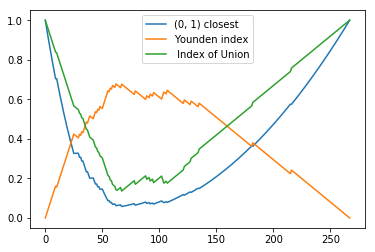

In [17]:
plt.plot(d_roc)
plt.plot(tpr - fpr)
plt.plot(abs((tpr - auc)) + abs((1-fpr - auc)))
plt.legend(['(0, 1) closest', 'Younden index', ' Index of Union'])
pass
#plt.savefig("plots/indeces_roc.svg", dpi=300)

In [18]:
thr_opt= thr[IU]
fpr_opt = fpr[IU]
tpr_opt = tpr[IU]
p=sum(y_roc==1)
n=sum(y_roc==0)

acc_opt = (p*tpr_opt + n*(1-fpr_opt))/float((p+n))

In [19]:
print(thr_opt, fpr_opt, tpr_opt)

(0.5294844929866783, 0.10900473933649289, 0.7857142857142857)


In [20]:
C_plane = np.log(thr_opt/(1-thr_opt))
w_0 = grid.best_estimator_.named_steps['clf'].intercept_
w_1, w_2, w_3, w_4 = grid.best_estimator_.named_steps['clf'].coef_.squeeze()

In [21]:
# Transform plane equation
center_opt = grid.best_estimator_.named_steps['scaler'].center_
scaling_opt = grid.best_estimator_.named_steps['scaler'].scale_

In [22]:
right_coef = np.round(C_plane - w_0[0] + sum(np.array([w_1, w_2, w_3, w_4])*center_opt/scaling_opt), 2)
denominators = np.round(scaling_opt/np.array([w_1,w_2,w_3, w_4]), 2)

print( np.round(scaling_opt, 2))
print( np.round(np.array([w_1,w_2,w_3, w_4]),2))
print( np.round(scaling_opt/np.array([w_1,w_2,w_3, w_4]),2))
print(np.round(right_coef,2))

[1.46000e+00 1.71780e+02 4.06000e+01 2.84909e+03]
[ 1.03 -0.31  0.25 -0.29]
[ 1.41000e+00 -5.62640e+02  1.61810e+02 -9.87112e+03]
0.99


In [23]:
plane_eq_text = r'$\left(\frac{\bf Breslow}{%.2f}\right) \
- \left(\frac{\bf GM-CSF }{%.2f}\right) \
+ \left(\frac{\bf IL-4}{%.2f} \right) \
-  \left(\frac{\bf DCD}{%.2f} \right) = %.2f $' % (abs(denominators[0]), 
                                                    abs(denominators[1]), 
                                                    abs(denominators[2]),
                                                    abs(denominators[3]),
                                                    right_coef)

In [24]:
from IPython.display import display, Math, Latex

Math(plane_eq_text)

<IPython.core.display.Math object>

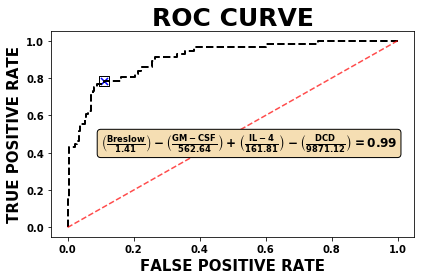

In [25]:
plt.plot(fpr, tpr, color='black', linewidth=2, linestyle='dashed')

#plt.scatter(fpr_opt,tpr_opt, c = 'blue', marker='x', s=100)
plt.scatter(fpr_opt,tpr_opt, marker='s', s=100,  facecolors='none', edgecolors='black')
plt.scatter(fpr_opt,tpr_opt, c = 'blue', marker='x', s=50)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FALSE POSITIVE RATE',size=15,weight='bold')
plt.ylabel('TRUE POSITIVE RATE',size=15,weight='bold')
plt.title('ROC CURVE',size=25, weight='bold')
plt.xticks(size=10, weight='bold')
plt.yticks(size=10, weight='bold')
plt.tight_layout()
plt.plot([0,1], [0, 1], 'r--', alpha=0.7)
plt.text(0.55, 0.45, plane_eq_text, horizontalalignment='center',size=12, weight='bold',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=1))
#plt.savefig('plots/roc_curves_training.svg', dpi=300)
pass